<a href="https://colab.research.google.com/github/JonasRiber/Dl_project_HAM10000/blob/main/Ham10000_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### trying to load
!pip install deeplake # install the deeplake package

import deeplake # import the deeplake package

ds = deeplake.load('hub://activeloop/ham10000')
ds.summary()

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ham10000



/

hub://activeloop/ham10000 loaded successfully.

Dataset(path='hub://activeloop/ham10000', read_only=True, tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])

      tensor           htype            shape           dtype  compression
      -------         -------          -------         -------  ------- 
       ages         class_label       (10015, 1)       uint32    None   
      genders       class_label       (10015, 1)       uint32    None   
     image_ids      class_label       (10015, 1)       uint32    None   
      images           image     (10015, 450, 600, 3)   uint8    jpeg   
 lesion_categories  class_label       (10015, 1)       uint32    None   
    lesion_ids      class_label       (10015, 1)       uint32    None   
   localizations    class_label       (10015, 1)       uint32    None   
      sources       class_label       (10015, 1)       uint32    None   


## Visualising data

(450, 600, 3)


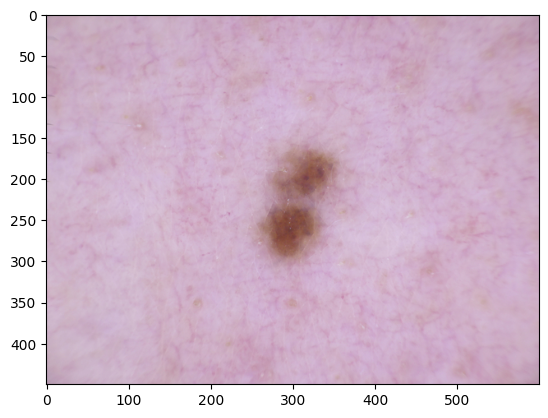

In [ ]:
import matplotlib.pyplot as plt
# showcase a single image
image = ds.images[0].numpy()

print(image.shape) # shape of the images
#show the image
plt.imshow(image)
plt.show()


In [ ]:
# Check the first few entries of the dataset
for sample in ds[:5]:
    print(sample)

Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([0]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([1]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([2]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([3]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([4]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])


## Base line model


In [ ]:
import numpy as np
# Extract images and labels
images = []
labels = []  # Define the labels list

# Iterate through the dataset
for sample in ds[:4000]:#[:200]just to speed up testing of the code
    images.append(sample['images'].numpy())  # Extract image data
    labels.append(sample['lesion_categories'].numpy())  # Extract lesion categories as labels

[]


In [ ]:
print(labels)

[array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([5], dtype=uint32), array([5], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([0], dtype=uint32), array([6], dtype=uint32), array([5], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([3], dtype=uint32), array([3], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([5], dtype=uint32), array([1], dtype=uint32), array([3], dtype=uint32), array([2], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([5], dtype=uint32), array([5], dtype=uint32), array([3], dtype=uint32), array([1], dtype=uint32), array([1], dtype=uint32), array([1], 

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Preprocess images: resize to 128x128 and normalize
images = np.array([img_to_array(array_to_img(image, scale=False).resize((128, 128))) for image in images])
images = images / 255.0  # Normalize pixel values between 0 and 1

# Convert labels to a flat array
labels = np.array(labels).flatten()



In [ ]:
def labels_count(labels):
    count = {}
    for label in labels:
        if label not in count:
            count[label] = 0
        count[label] += 1
    return count
print(labels_count(labels))
print(3316/5000)
print(set(labels))


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

{1: 3316, 5: 259, 0: 544, 6: 167, 3: 586, 2: 65, 4: 63}
0.6632
{0, 1, 2, 3, 4, 5, 6}
(4000, 128, 128, 3)
(4000, 7)
(1000, 128, 128, 3)
(1000, 7)


## Balance the dataset

In [ ]:
import numpy as np

def balance_dataset(images, labels, num_samples_per_class=63): ## num_samples_per_class: change to control class size
  """Balances the dataset by undersampling.

  Args:
    images: List of images.
    labels: List of corresponding labels.
    num_samples_per_class: The desired number of samples per class.

  Returns:
    balanced_images: List of balanced images.
    balanced_labels: List of balanced labels.
  """

  unique_labels = set(labels)
  balanced_images = []
  balanced_labels = []

  for label in unique_labels:
    indices = [i for i, x in enumerate(labels) if x == label]
    if len(indices) > num_samples_per_class:
      indices = np.random.choice(indices, size=num_samples_per_class, replace=False)
    balanced_images.extend(images[i] for i in indices)
    balanced_labels.extend(labels[i] for i in indices)

  return np.array(balanced_images), np.array(balanced_labels)

# Example usage
balanced_images, balanced_labels = balance_dataset(images, labels)


## intalize x and y

In [ ]:
## normal

'''
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
'''
## undersampled

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42, stratify=balanced_labels) # Use balanced_labels for stratification

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)



In [ ]:
print(labels_count(balanced_labels))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

{0: 63, 1: 63, 2: 63, 3: 63, 4: 63, 5: 63, 6: 63}
(352, 128, 128, 3)
(352, 7)
(89, 128, 128, 3)
(89, 7)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation="relu", input_shape=(128, 128, 3)),  # 1st Conv Layer with input shape
    layers.MaxPooling2D((2, 2)),  # 1st MaxPooling Layer
    layers.Conv2D(32, (3, 3), activation="relu"),  # 2nd Conv Layer
    layers.MaxPooling2D((2, 2)),  # 2nd MaxPooling Layer
    layers.Conv2D(64, (3, 3), activation="relu"),  # 3rd Conv Layer
    layers.Flatten(),  # Flatten the 2D output into 1D
    layers.Dense(64, activation="relu"),  # Fully connected layer
    layers.Dense(7, activation="softmax"),  # Output layer with 7 classes (use softmax for multi-class classification)
])

# Compile the model
model.compile(optimizer='adam',  # Adam optimizer
              loss='categorical_crossentropy',  # Cross-entropy loss for multi-class classification
              metrics=['accuracy'])  # We want to track accuracy during training

# Summary of the model
model.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,235,367 (12.34 MB)

 Trainable params: 3,235,367 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import set_random_seed

set_random_seed(0) # make weight initialization deterministic

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(266)) # W1*x + b
model.add(Activation('relu')) # ReLU(W1*x + b)
model.add(Dropout(0.5))
model.add(Dense(7)) # W2*x + b
model.add(Activation('softmax')) # softmax(W2*x + b)

## Run model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Initiate Adam optimizer (a variant of Stochastic Gradient Descent)
# (Note: this choice is somewhat arbitrary - see options here: https://keras.io/api/optimizers/)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


# Normalize image data
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255.0  # Normalize images to range [0, 1]
x_test /= 255.0


data_augmentation = True
epochs = 100
batch_size = 16

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train,
                           batch_size=batch_size),
              epochs=epochs,
              validation_data=(x_test, y_test),

              shuffle=True)

Using real-time data augmentation.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.2479 - loss: 1.8180 - val_accuracy: 0.1798 - val_loss: 1.8599
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2670 - loss: 1.8050 - val_accuracy: 0.2584 - val_loss: 1.8273
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2425 - loss: 1.8147 - val_accuracy: 0.2360 - val_loss: 1.8088
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.2786 - loss: 1.8108 - val_accuracy: 0.2697 - val_loss: 1.8099
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2627 - loss: 1.8038 - val_accuracy: 0.2584 - val_loss: 1.8081
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2759 - loss: 1.7687 - val_accuracy: 0.2472 - val_loss: 1.7915
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.2756 - loss: 1.7835 - val_accuracy: 0.2697 - val_loss: 1.7744
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3411 - loss: 1.7346 - val_accuracy: 0.2472 - val_l

## Testing model

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


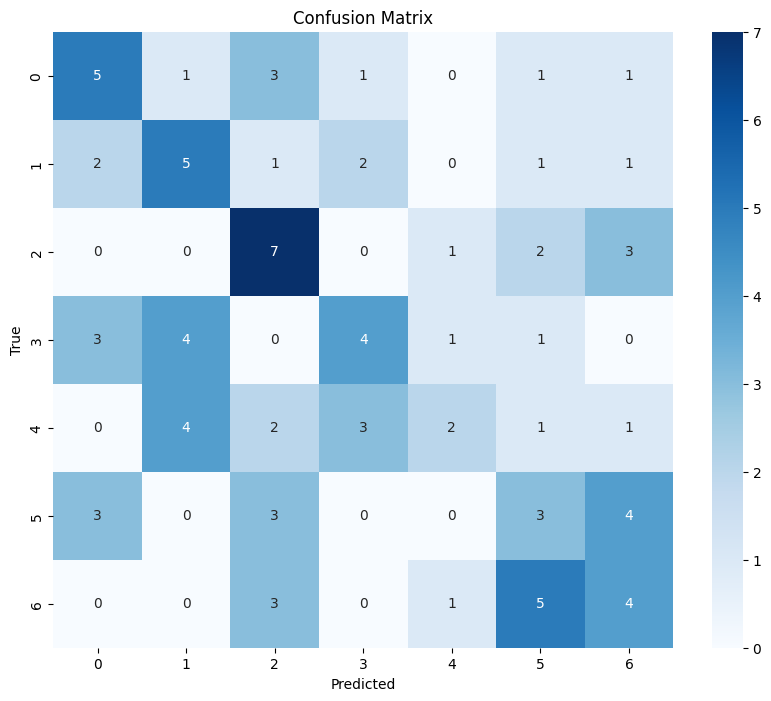

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have 'model', 'x_test', and 'y_test' defined
# and 'results = model.evaluate(x_test, y_test, batch_size=32)' has been executed

# 1. Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
#print(y_pred_classes)

# 2. Get true labels
y_true_classes = np.argmax(y_test, axis=1)
#print(y_true_classes)

# 3. Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4', '5', '6'],
            yticklabels=['0', '1', '2', '3', '4', '5', '6'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(y_pred)

[[0.18350981 0.1988916  0.05900868 ... 0.0597212  0.17919207 0.12651832]
 [0.19691078 0.21853237 0.04259611 ... 0.05087674 0.15611999 0.10898164]
 [0.16989553 0.26886225 0.03621658 ... 0.04862026 0.12860438 0.09376983]
 ...
 [0.19142576 0.2120634  0.04991757 ... 0.0542019  0.15982537 0.11889581]
 [0.16732417 0.18021056 0.07440422 ... 0.06551038 0.21115136 0.13483231]
 [0.2198656  0.22386925 0.02917236 ... 0.03884822 0.12655725 0.09454829]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


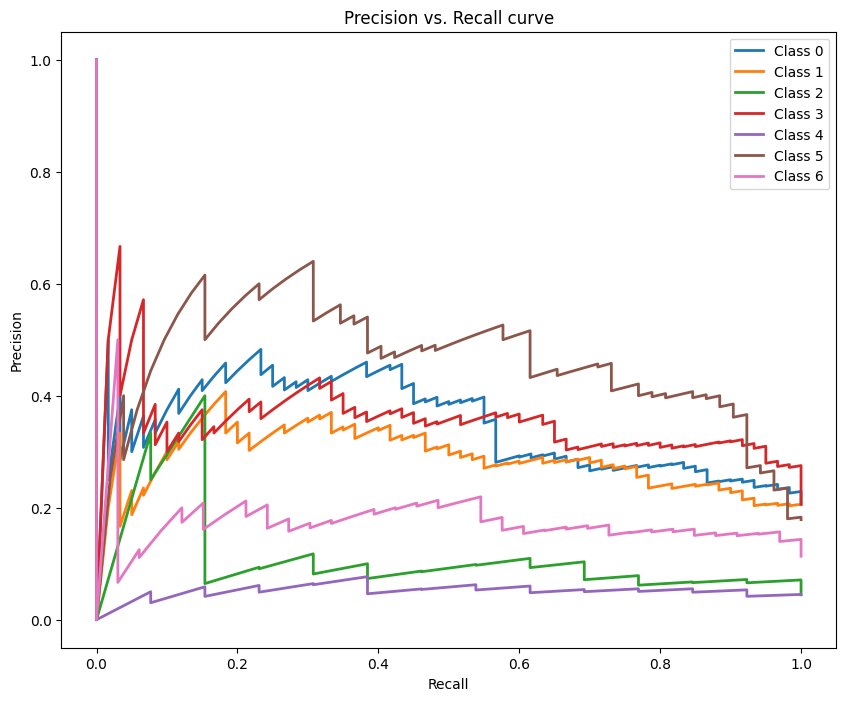

Average precision for class 0: 0.3559
Average precision for class 1: 0.2933
Average precision for class 2: 0.1333
Average precision for class 3: 0.3634
Average precision for class 4: 0.0579
Average precision for class 5: 0.4672
Average precision for class 6: 0.1871


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming you have 'model', 'x_test', and 'y_test' defined
# and 'results = model.evaluate(x_test, y_test, batch_size=32)' has been executed

# 1. Get predictions
y_pred = model.predict(x_test)

# 2. Calculate precision-recall for each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 7 # 7 classes
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# 3. Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

# 4. Calculate and print average precision for each class
for i in range(n_classes):
    print(f"Average precision for class {i}: {average_precision[i]:.4f}")